<a href="https://colab.research.google.com/github/sunilvengalil/BloodVesselSegment/blob/master/fundal_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing Google colab

1. Go to google colab

   https://colab.research.google.com/notebooks/intro.ipynb

2. Create a new notebook using menu File -> New Notebook
 
3. Rename the notebook to fundal_image_segmentation.ipynb

4. Change the runtime enviroment to GPU



> Go to Menu Runtime -> Change Runtime type. From the dropdown select 'GPU'. Click on 'Save' button


# 1. Mount google drive
Mount `MyDrive` in your google drive as  `/content/gdrive`

While running the following cell, you will be prompted to click on a link in order to generate access key to access your google drive. 

Copy paste the acess key into the input field and press Enter

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")



Mounted at /content/gdrive


Check the current working directory and list the files/folders in current directory

In [2]:
!pwd
!ls

/content
gdrive	sample_data


# 2. Get the code from github

Create a new directory `fundal_image` and download code and data from github `https://github.com/juntang-zhuang/LadderNet.git`

In [3]:
%cd /content/gdrive/MyDrive
#!mkdir fundal_image
%cd fundal_image
#!git clone https://github.com/juntang-zhuang/LadderNet.git

/content/gdrive/MyDrive
/content/gdrive/MyDrive/fundal_image


# 3. Display sample training image from DRIVE dataset

In [4]:
from IPython.display import Image
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

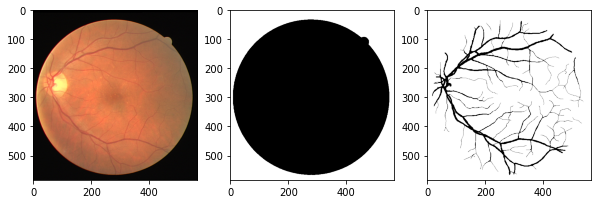

In [5]:

train_img = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/images/21_training.tif")
train_mask = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/mask/21_training_mask.gif")
train_gt = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/1st_manual/21_manual1.gif")

fig = plt.figure(figsize= (10,20))
ax = fig.add_subplot(1, 3, 1 )
ax.imshow(train_img)
ax2 = fig.add_subplot(1, 3, 2 )
ax2.imshow(train_mask, cmap="Greys")
ax3 = fig.add_subplot(1, 3, 3 )
ax3.imshow(train_gt, cmap="Greys")

plt.show()


# 4. Edit the configuration file

Open the file `gdrive/Mydrive/fundal_image/LadderNet/` configuration.txt and modify the values of following configuration parameters to below mentioned values

```
N_subimgs=1900
N_epochs=200
Batch_size=32
average_mode = False
```






# Helper Functions

In [6]:
import h5py
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

def load_hdf5(infile):
  with h5py.File(infile,"r") as f:  #"with" close the file after its nested commands
    return f["image"][()]

def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)

#convert RGB image in black and white
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

# group a set of images row per columns
def group_images(data, per_row):
    assert data.shape[0]%per_row==0
    assert (data.shape[1]==1 or data.shape[1]==3)
    data = np.transpose(data,(0, 2, 3, 1))  #corect format for imshow
    all_stripe = []
    for i in range(int(data.shape[0]/per_row)):
        stripe = data[i * per_row]
        for k in range(i * per_row + 1, i * per_row+per_row):
            stripe = np.concatenate((stripe, data[k]), axis=1)
        all_stripe.append(stripe)
    totimg = all_stripe[0]
    for i in range(1, len(all_stripe)):
        totimg = np.concatenate((totimg, all_stripe[i]), axis=0)
    return totimg


#visualize image (as PIL image, NOT as matplotlib!)
def visualize(data,filename):
    assert (len(data.shape)==3) #height*width*channels
    img = None
    if data.shape[2]==1:  #in case it is black and white
        data = np.reshape(data,(data.shape[0],data.shape[1]))
    if np.max(data)>1:
        img = Image.fromarray(data.astype(np.uint8))   #the image is already 0-255
    else:
        img = Image.fromarray((data*255).astype(np.uint8))  #the image is between 0-1
    img.save(filename + '.png')
    return img


def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,2)
    assert (pred.shape[2]==2 )  #check the classes are 2
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1]
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i,pix]=1
                else:
                    pred_images[i,pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 5. Prepare training and test data 

Read the test and train data and save as hd5 file format

In [7]:
%cd LadderNet
!python3 prepare_datasets_DRIVE.py

/content/gdrive/My Drive/fundal_image/LadderNet
original image: 21_training.tif
ground truth name: 21_manual1.gif
border masks name: 21_training_mask.gif
original image: 22_training.tif
ground truth name: 22_manual1.gif
border masks name: 22_training_mask.gif
original image: 23_training.tif
ground truth name: 23_manual1.gif
border masks name: 23_training_mask.gif
original image: 24_training.tif
ground truth name: 24_manual1.gif
border masks name: 24_training_mask.gif
original image: 25_training.tif
ground truth name: 25_manual1.gif
border masks name: 25_training_mask.gif
original image: 26_training.tif
ground truth name: 26_manual1.gif
border masks name: 26_training_mask.gif
original image: 27_training.tif
ground truth name: 27_manual1.gif
border masks name: 27_training_mask.gif
original image: 28_training.tif
ground truth name: 28_manual1.gif
border masks name: 28_training_mask.gif
original image: 29_training.tif
ground truth name: 29_manual1.gif
border masks name: 29_training_mask.gi

# 6. Train the ladder netwrok

In [8]:
%cd /content/gdrive/MyDrive/fundal_image/LadderNet/src


/content/gdrive/MyDrive/fundal_image/LadderNet/src


## Load configuration settings

In [9]:
from six.moves import configparser

#=========  Load settings from Config file
config = configparser.RawConfigParser()
config.read('../configuration.txt')

#path to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
name_experiment = config.get('experiment name', 'name')
#training settings
N_epochs = int(config.get('training settings', 'N_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))


## Define parameters

In [10]:
import os
import torch
import numpy as np

# log file
if not os.path.exists('./logs'):
    os.mkdir('logs')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

start_epoch = 0  # start from epoch 0 or last checkpoint epoch
total_epoch = N_epochs

val_portion = 0.1

lr_epoch = np.array([150,total_epoch])
lr_value= np.array([0.001,0.0001])

layers = 4
filters = 10


## Build the network

In [11]:
import torch
import torch.nn.functional as F  # Various activation functions
import torch.nn as nn

drop = 0.25

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)


class BasicBlock(nn.Module):
    """
    Implements Shared weight residual block
    """
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        if inplanes!= planes:
            self.conv0 = conv3x3(inplanes,planes)

        self.inplanes = inplanes
        self.planes = planes

        self.conv1 = conv3x3(planes, planes, stride)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        #self.conv2 = conv3x3(planes, planes)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.drop = nn.Dropout2d(p=drop)

    def forward(self, x):
        if self.inplanes != self.planes:
            x = self.conv0(x)
            x = F.relu(x)

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.drop(out)

        out1 = self.conv1(out)
        #out1 = self.relu(out1)

        out2 = out1 + x

        return F.relu(out2)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Initial_LadderBlock(nn.Module):

    def __init__(self, planes, layers, kernel=3, block=BasicBlock, inplanes = 3):
        super().__init__()
        self.planes = planes
        self.layers = layers
        self.kernel = kernel

        self.padding = int((kernel-1)/2)
        self.inconv = nn.Conv2d(in_channels=inplanes,out_channels=planes,
                                kernel_size=3,stride=1,padding=1,bias=True)

        # create module list for down branch
        self.down_module_list = nn.ModuleList()
        for i in range(0, layers):
            self.down_module_list.append(block(planes*(2**i), planes*(2**i)))

        # use strided conv instead of poooling
        self.down_conv_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_conv_list.append(nn.Conv2d(planes*2**i,
                                                 planes*2**(i+1),
                                                 stride=2,
                                                 kernel_size=kernel,
                                                 padding=self.padding))

        # create module for bottom block
        self.bottom = block(planes*(2**layers),
                            planes*(2**layers))

        # create module list for up branch
        self.up_conv_list = nn.ModuleList()
        self.up_dense_list = nn.ModuleList()
        for i in range(0, layers):
            self.up_conv_list.append(nn.ConvTranspose2d(in_channels=planes*2**(layers-i),
                                                        out_channels=planes*2**max(0,layers-i-1),
                                                        kernel_size=3,
                                                        stride=2,
                                                        padding=1,
                                                        output_padding=1,
                                                        bias=True)
                                     )
            self.up_dense_list.append(block(planes*2**max(0,layers-i-1), 
                                            planes*2**max(0,layers-i-1)))


    def forward(self, x):
        out = self.inconv(x)
        out = F.relu(out)

        down_out = []
        # down branch
        for i in range(0, self.layers):
            out = self.down_module_list[i](out)
            down_out.append(out)
            out = self.down_conv_list[i](out)
            out = F.relu(out)

        # bottom branch
        out = self.bottom(out)
        bottom = out

        # up branch
        up_out = []
        up_out.append(bottom)

        for j in range(0, self.layers):
            out = self.up_conv_list[j](out) + down_out[self.layers-j-1]
            #out = F.relu(out)
            out = self.up_dense_list[j](out)
            up_out.append(out)

        return up_out

class LadderBlock(nn.Module):

    def __init__(self,planes,layers,kernel=3,block=BasicBlock,inplanes = 3):
        super().__init__()
        self.planes = planes
        self.layers = layers
        self.kernel = kernel

        self.padding = int((kernel-1)/2)
        self.inconv = block(planes,planes)

        # create module list for down branch
        self.down_module_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_module_list.append(block(planes*(2**i),planes*(2**i)))

        # use strided conv instead of poooling
        self.down_conv_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_conv_list.append(nn.Conv2d(planes*2**i,planes*2**(i+1),stride=2,kernel_size=kernel,padding=self.padding))

        # create module for bottom block
        self.bottom = block(planes*(2**layers),planes*(2**layers))

        # create module list for up branch
        self.up_conv_list = nn.ModuleList()
        self.up_dense_list = nn.ModuleList()
        for i in range(0, layers):
            self.up_conv_list.append(nn.ConvTranspose2d(planes*2**(layers-i), planes*2**max(0,layers-i-1), kernel_size=3,
                                                        stride=2,padding=1,output_padding=1,bias=True))
            self.up_dense_list.append(block(planes*2**max(0,layers-i-1),planes*2**max(0,layers-i-1)))


    def forward(self, x):
        out = self.inconv(x[-1])

        down_out = []
        # down branch
        for i in range(0,self.layers):
            out = out + x[-i-1]
            out = self.down_module_list[i](out)
            down_out.append(out)

            out = self.down_conv_list[i](out)
            out = F.relu(out)

        # bottom branch
        out = self.bottom(out)
        bottom = out

        # up branch
        up_out = []
        up_out.append(bottom)

        for j in range(0,self.layers):
            out = self.up_conv_list[j](out) + down_out[self.layers-j-1]
            #out = F.relu(out)
            out = self.up_dense_list[j](out)
            up_out.append(out)

        return up_out

class Final_LadderBlock(nn.Module):

    def __init__(self,planes,layers,kernel=3,block=BasicBlock,inplanes = 3):
        super().__init__()
        self.block = LadderBlock(planes,layers,kernel=kernel,block=block)

    def forward(self, x):
        out = self.block(x)
        return out[-1]

class LadderNetv6(nn.Module):
    def __init__(self,layers=3,filters=16,num_classes=2,inplanes=3):
        super().__init__()
        self.initial_block = Initial_LadderBlock(planes=filters,layers=layers,inplanes=inplanes)
        #self.middle_block = LadderBlock(planes=filters,layers=layers)
        self.final_block = Final_LadderBlock(planes=filters,layers=layers)
        self.final = nn.Conv2d(in_channels=filters,out_channels=num_classes,kernel_size=1)

    def forward(self,x):
        out = self.initial_block(x)
        #out = self.middle_block(out)
        out = self.final_block(out)
        out = self.final(out)
        #out = F.relu(out)
        out = F.log_softmax(out,dim=1)
        return out

In [25]:

class LossMulti:
    def __init__(self, jaccard_weight=0, class_weights=None, num_classes=1):
        if class_weights is not None:
            nll_weight = cuda(
                torch.from_numpy(class_weights.astype(np.float32)))
        else:
            nll_weight = None
        self.nll_loss = nn.NLLLoss2d(weight=nll_weight)
        self.jaccard_weight = jaccard_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            for cls in range(self.num_classes):
                jaccard_target = (targets == cls).float()
                jaccard_output = outputs[:, cls].exp()
                intersection = (jaccard_output * jaccard_target).sum()

                union = jaccard_output.sum() + jaccard_target.sum()
                loss -= torch.log((intersection + eps) / (union - intersection + eps)) * self.jaccard_weight
        return loss

import torch.nn as nn

import torch.optim as optim

net = LadderNetv6(num_classes=2,layers=layers,filters=filters, inplanes=1)
print("Toral number of parameters: "+str(count_parameters(net)))

check_path = 'LadderNetv65_layer_%d_filter_%d.pt7'% (layers,filters) #'UNet16.pt7'#'UNet_Resnet101.pt7'

resume = False

#criterion = torch.nn.NLLLoss2d()
criterion = LossMulti(jaccard_weight=0.2)
#criterion = CrossEntropy2d()

#optimizer = optim.SGD(net.parameters(),
#                     lr=lr_schedule[0], momentum=0.9, weight_decay=5e-4, nesterov=True)

optimizer = optim.Adam(net.parameters(),lr=lr_value[0])


Toral number of parameters: 1381652


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


## Define functions to preprocess images

In [26]:
###################################################
#
#   Script to pre-process the original imgs
#
##################################################


import numpy as np
from PIL import Image
import cv2


#My pre processing (use for both training and testing!)
def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    return train_imgs


#============================================================
#========= PRE PROCESSING FUNCTIONS ========================#
#============================================================

#==== histogram equalization
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs


## Define functions to create training data

In [27]:
import random

#extract patches randomly in the full training images
#  -- Inside OR in full image
def extract_random(full_imgs,full_masks, patch_h,patch_w, N_patches, inside=True):
    if (N_patches%full_imgs.shape[0] != 0):
        print("N_patches: plase enter a multiple of 20")
        exit()
    assert (len(full_imgs.shape)==4 and len(full_masks.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    assert (full_masks.shape[1]==1)   #masks only black and white
    assert (full_imgs.shape[2] == full_masks.shape[2] and full_imgs.shape[3] == full_masks.shape[3])
    patches = np.empty((N_patches,full_imgs.shape[1],patch_h,patch_w))
    patches_masks = np.empty((N_patches,full_masks.shape[1],patch_h,patch_w))
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    # (0,0) in the center of the image
    patch_per_img = int(N_patches/full_imgs.shape[0])  #N_patches equally divided in the full images
    print("patches per full image: " +str(patch_per_img))
    iter_tot = 0   #iter over the total numbe rof patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        k=0
        while k <patch_per_img:
            x_center = random.randint(0+int(patch_w/2),img_w-int(patch_w/2))
            # print "x_center " +str(x_center)
            y_center = random.randint(0+int(patch_h/2),img_h-int(patch_h/2))
            # print "y_center " +str(y_center)
            #check whether the patch is fully contained in the FOV
            if inside==True:
                if is_patch_inside_FOV(x_center,y_center,img_w,img_h,patch_h)==False:
                    continue
            patch = full_imgs[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patch_mask = full_masks[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patches[iter_tot]=patch
            patches_masks[iter_tot]=patch_mask
            iter_tot +=1   #total
            k+=1  #per full_img
    return patches, patches_masks

#data consinstency check
def data_consistency_check(imgs,masks):
    assert(len(imgs.shape)==len(masks.shape))
    assert(imgs.shape[0]==masks.shape[0])
    assert(imgs.shape[2]==masks.shape[2])
    assert(imgs.shape[3]==masks.shape[3])
    assert(masks.shape[1]==1)
    assert(imgs.shape[1]==1 or imgs.shape[1]==3)

# Load the original data and return the extracted patches for training/testing
def get_data_training(DRIVE_train_imgs_original,
                      DRIVE_train_groudTruth,
                      patch_height,
                      patch_width,
                      N_subimgs,
                      inside_FOV):
    train_imgs_original = load_hdf5(DRIVE_train_imgs_original)
    train_masks = load_hdf5(DRIVE_train_groudTruth) #masks always the same
    # visualize(group_images(train_imgs_original[0:20,:,:,:],5),'imgs_train')#.show()  #check original imgs train


    train_imgs = my_PreProc(train_imgs_original)
    train_masks = train_masks/255.

    train_imgs = train_imgs[:,:,9:574,:]  #cut bottom and top so now it is 565*565
    train_masks = train_masks[:,:,9:574,:]  #cut bottom and top so now it is 565*565
    data_consistency_check(train_imgs,train_masks)

    #check masks are within 0-1
    assert(np.min(train_masks)==0 and np.max(train_masks)==1)

    print("\ntrain images/masks shape:")
    print(train_imgs.shape)
    print("train images range (min-max): " +str(np.min(train_imgs)) +' - '+str(np.max(train_imgs)))
    print("train masks are within 0-1\n")

    #extract the TRAINING patches from the full images
    patches_imgs_train, patches_masks_train = extract_random(train_imgs,train_masks,patch_height,patch_width,N_subimgs,inside_FOV)
    data_consistency_check(patches_imgs_train, patches_masks_train)

    print("\ntrain PATCHES images/masks shape:")
    print(patches_imgs_train.shape)
    print("train PATCHES images range (min-max): " +str(np.min(patches_imgs_train)) +' - '+str(np.max(patches_imgs_train)))

    return patches_imgs_train, patches_masks_train#, patches_imgs_test, patches_masks_test

## Define Dataset class

In [28]:
from torch.utils.data import Dataset, DataLoader

#============ Load the data and divided in patches
patches_imgs_train, patches_masks_train = get_data_training(
    DRIVE_train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    DRIVE_train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    N_subimgs = int(config.get('training settings', 'N_subimgs')),
    inside_FOV = config.getboolean('training settings', 'inside_FOV') #select the patches only inside the FOV  (default == True)
)

class TrainDataset(Dataset):
    """Endovis 2018 dataset."""

    def __init__(self, patches_imgs, patches_masks_train):
        self.imgs = patches_imgs
        self.masks = patches_masks_train

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        tmp = self.masks[idx]
        tmp = np.squeeze(tmp,0)
        return torch.from_numpy(self.imgs[idx,...]).float(), torch.from_numpy(tmp).long()

val_ind = random.sample(range(patches_masks_train.shape[0]),int(np.floor(val_portion*patches_masks_train.shape[0])))

train_ind =  set(range(patches_masks_train.shape[0])) - set(val_ind)
train_ind = list(train_ind)

train_set = TrainDataset(patches_imgs_train[train_ind,...],patches_masks_train[train_ind,...])
train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)

val_set = TrainDataset(patches_imgs_train[val_ind,...],patches_masks_train[val_ind,...])
val_loader = DataLoader(val_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)




train images/masks shape:
(20, 1, 565, 565)
train images range (min-max): 0.0 - 1.0
train masks are within 0-1

patches per full image: 95

train PATCHES images/masks shape:
(1900, 1, 48, 48)
train PATCHES images range (min-max): 0.00784313725490196 - 1.0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Define functions for train and evaluate

In [29]:
import torch.backends.cudnn as cudnn

best_loss = np.Inf

# create a list of learning rate with epochs
lr_schedule = np.zeros(total_epoch)
for l in range(len(lr_epoch)):
    if l ==0:
        lr_schedule[0:lr_epoch[l]] = lr_value[l]
    else:
        lr_schedule[lr_epoch[l-1]:lr_epoch[l]] = lr_value[l]

if device == 'cuda':
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+check_path)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    IoU = []

    # get learning rate from learing schedule
    lr = lr_schedule[epoch]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    print("Learning rate = %4f\n" % lr)

    IU = []
    # train network
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print("Epoch %d: Train loss %4f\n" % (epoch, train_loss / np.float32(len(train_loader))))

In [30]:
def validate(epoch, display=False):
    global best_loss
    net.eval()
    test_loss = 0
    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

        print(
            'Valid loss: {:.4f}'.format(test_loss))
    # Save checkpoint.
    if test_loss < best_loss:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'best_loss': best_loss,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + check_path)
        best_loss = test_loss

## Start training

In [31]:
from tqdm import tqdm

for epoch in range(start_epoch, total_epoch):
    train(epoch)
    validate(epoch, False)

  0%|          | 0/27 [00:00<?, ?it/s]


Epoch: 0
Learning rate = 0.001000



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 27/27 [00:01<00:00, 16.73it/s]

Epoch 0: Train loss 0.380705



Valid loss: 0.9349
Saving..


  0%|          | 0/27 [00:00<?, ?it/s]


Epoch: 1
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.51it/s]

Epoch 1: Train loss 0.293255




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8540
Saving..

Epoch: 2
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.52it/s]

Epoch 2: Train loss 0.277962




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8378
Saving..

Epoch: 3
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.63it/s]

Epoch 3: Train loss 0.274471




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8217
Saving..

Epoch: 4
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.19it/s]

Epoch 4: Train loss 0.263999




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7795
Saving..

Epoch: 5
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.53it/s]

Epoch 5: Train loss 0.239260




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6446
Saving..

Epoch: 6
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.74it/s]

Epoch 6: Train loss 0.195935




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5690
Saving..

Epoch: 7
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.28it/s]

Epoch 7: Train loss 0.168175




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4650
Saving..

Epoch: 8
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.46it/s]

Epoch 8: Train loss 0.148162




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4281
Saving..

Epoch: 9
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.52it/s]

Epoch 9: Train loss 0.144304




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4134
Saving..

Epoch: 10
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.75it/s]

Epoch 10: Train loss 0.136265




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4012
Saving..

Epoch: 11
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.79it/s]

Epoch 11: Train loss 0.131780




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3901
Saving..

Epoch: 12
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.38it/s]

Epoch 12: Train loss 0.128818




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3850
Saving..

Epoch: 13
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.34it/s]

Epoch 13: Train loss 0.126136




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3763
Saving..

Epoch: 14
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.73it/s]

Epoch 14: Train loss 0.121853




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3737
Saving..

Epoch: 15
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.46it/s]

Epoch 15: Train loss 0.122574




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3926

Epoch: 16
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.45it/s]

Epoch 16: Train loss 0.120078




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3682
Saving..

Epoch: 17
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.78it/s]

Epoch 17: Train loss 0.115165




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3610
Saving..

Epoch: 18
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.55it/s]

Epoch 18: Train loss 0.112231




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3612

Epoch: 19
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.30it/s]

Epoch 19: Train loss 0.110405




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3730

Epoch: 20
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.61it/s]

Epoch 20: Train loss 0.109012




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3569
Saving..

Epoch: 21
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.57it/s]

Epoch 21: Train loss 0.105133




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3601

Epoch: 22
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.56it/s]

Epoch 22: Train loss 0.101648




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3600

Epoch: 23
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.12it/s]

Epoch 23: Train loss 0.099984




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3663

Epoch: 24
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.93it/s]

Epoch 24: Train loss 0.096943




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3596

Epoch: 25
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.48it/s]

Epoch 25: Train loss 0.094216




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3646

Epoch: 26
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 26: Train loss 0.091767




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3565
Saving..

Epoch: 27
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.47it/s]

Epoch 27: Train loss 0.089409




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3641

Epoch: 28
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.25it/s]

Epoch 28: Train loss 0.086880




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3698

Epoch: 29
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.57it/s]

Epoch 29: Train loss 0.086061




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3731

Epoch: 30
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.80it/s]

Epoch 30: Train loss 0.084477




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3838

Epoch: 31
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.43it/s]

Epoch 31: Train loss 0.081578




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3787

Epoch: 32
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.29it/s]

Epoch 32: Train loss 0.079373




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3796

Epoch: 33
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.81it/s]

Epoch 33: Train loss 0.078822




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3857

Epoch: 34
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.65it/s]

Epoch 34: Train loss 0.075980




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4260

Epoch: 35
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.30it/s]

Epoch 35: Train loss 0.074195




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3938

Epoch: 36
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.28it/s]

Epoch 36: Train loss 0.073287




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3977

Epoch: 37
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 37: Train loss 0.071398




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4107

Epoch: 38
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.29it/s]

Epoch 38: Train loss 0.070400




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4111

Epoch: 39
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 39: Train loss 0.068406




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4117

Epoch: 40
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.23it/s]

Epoch 40: Train loss 0.066725




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4196

Epoch: 41
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 41: Train loss 0.065321




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4218

Epoch: 42
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.84it/s]

Epoch 42: Train loss 0.064337




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4450

Epoch: 43
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.08it/s]

Epoch 43: Train loss 0.063346




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4342

Epoch: 44
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 16.52it/s]

Epoch 44: Train loss 0.062306




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4458

Epoch: 45
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.34it/s]

Epoch 45: Train loss 0.061015




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4603

Epoch: 46
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.02it/s]

Epoch 46: Train loss 0.059803




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4507

Epoch: 47
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.26it/s]

Epoch 47: Train loss 0.059767




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4762

Epoch: 48
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 48: Train loss 0.058710




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4670

Epoch: 49
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.91it/s]

Epoch 49: Train loss 0.058056




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4718

Epoch: 50
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.58it/s]

Epoch 50: Train loss 0.057178




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4883

Epoch: 51
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.15it/s]

Epoch 51: Train loss 0.055910




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4766

Epoch: 52
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.07it/s]

Epoch 52: Train loss 0.054696




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4686

Epoch: 53
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.45it/s]

Epoch 53: Train loss 0.054056




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5163

Epoch: 54
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.62it/s]

Epoch 54: Train loss 0.052794




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5043

Epoch: 55
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.19it/s]

Epoch 55: Train loss 0.052202




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5191

Epoch: 56
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.83it/s]

Epoch 56: Train loss 0.051484




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4921

Epoch: 57
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.25it/s]

Epoch 57: Train loss 0.051251




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5197

Epoch: 58
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.30it/s]

Epoch 58: Train loss 0.050140




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4978

Epoch: 59
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.35it/s]

Epoch 59: Train loss 0.049391




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5324

Epoch: 60
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.18it/s]

Epoch 60: Train loss 0.048266




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5181

Epoch: 61
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.10it/s]

Epoch 61: Train loss 0.047589




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5721

Epoch: 62
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.95it/s]

Epoch 62: Train loss 0.047435




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5318

Epoch: 63
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.10it/s]

Epoch 63: Train loss 0.047067




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5593

Epoch: 64
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.26it/s]

Epoch 64: Train loss 0.046118




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5771

Epoch: 65
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.27it/s]

Epoch 65: Train loss 0.045643




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5552

Epoch: 66
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.24it/s]

Epoch 66: Train loss 0.045596




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5797

Epoch: 67
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.50it/s]

Epoch 67: Train loss 0.045021




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5706

Epoch: 68
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.98it/s]

Epoch 68: Train loss 0.043995




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5579

Epoch: 69
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.72it/s]

Epoch 69: Train loss 0.043158




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5898

Epoch: 70
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.46it/s]

Epoch 70: Train loss 0.042961




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6112

Epoch: 71
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.08it/s]

Epoch 71: Train loss 0.042586




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6049

Epoch: 72
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.95it/s]

Epoch 72: Train loss 0.042129




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6059

Epoch: 73
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.41it/s]

Epoch 73: Train loss 0.041223




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5960

Epoch: 74
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.08it/s]

Epoch 74: Train loss 0.040506




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5960

Epoch: 75
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.36it/s]

Epoch 75: Train loss 0.040103




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5830

Epoch: 76
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.33it/s]

Epoch 76: Train loss 0.039948




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6336

Epoch: 77
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.96it/s]

Epoch 77: Train loss 0.039358




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5992

Epoch: 78
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.09it/s]

Epoch 78: Train loss 0.039355




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6527

Epoch: 79
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.14it/s]

Epoch 79: Train loss 0.038605




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6260

Epoch: 80
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.23it/s]

Epoch 80: Train loss 0.038078




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6643

Epoch: 81
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.89it/s]

Epoch 81: Train loss 0.037924




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6447

Epoch: 82
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.98it/s]

Epoch 82: Train loss 0.037157




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6645

Epoch: 83
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.49it/s]

Epoch 83: Train loss 0.036786




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6468

Epoch: 84
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.78it/s]

Epoch 84: Train loss 0.036562




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6865

Epoch: 85
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.13it/s]

Epoch 85: Train loss 0.036001




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6833

Epoch: 86
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.11it/s]

Epoch 86: Train loss 0.035637




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6919

Epoch: 87
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.11it/s]

Epoch 87: Train loss 0.035267




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6526

Epoch: 88
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.92it/s]

Epoch 88: Train loss 0.035208




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6850

Epoch: 89
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.73it/s]

Epoch 89: Train loss 0.034919




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7176

Epoch: 90
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.17it/s]

Epoch 90: Train loss 0.034490




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6513

Epoch: 91
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.16it/s]

Epoch 91: Train loss 0.034297




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7238

Epoch: 92
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.20it/s]

Epoch 92: Train loss 0.034096




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6829

Epoch: 93
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.12it/s]

Epoch 93: Train loss 0.033780




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6715

Epoch: 94
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.15it/s]

Epoch 94: Train loss 0.033232




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7618

Epoch: 95
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.03it/s]

Epoch 95: Train loss 0.033401




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6959

Epoch: 96
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.03it/s]

Epoch 96: Train loss 0.032451




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7409

Epoch: 97
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.22it/s]

Epoch 97: Train loss 0.032556




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6967

Epoch: 98
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.88it/s]

Epoch 98: Train loss 0.032679




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6878

Epoch: 99
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.90it/s]

Epoch 99: Train loss 0.031965




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8004

Epoch: 100
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.72it/s]

Epoch 100: Train loss 0.031554




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7140

Epoch: 101
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.05it/s]

Epoch 101: Train loss 0.031329




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7336

Epoch: 102
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.00it/s]

Epoch 102: Train loss 0.031006




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8293

Epoch: 103
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.76it/s]

Epoch 103: Train loss 0.031014




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7446

Epoch: 104
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.16it/s]

Epoch 104: Train loss 0.030028




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7576

Epoch: 105
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 105: Train loss 0.029946




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7395

Epoch: 106
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.09it/s]

Epoch 106: Train loss 0.029713




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7657

Epoch: 107
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.01it/s]

Epoch 107: Train loss 0.029205




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7768

Epoch: 108
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.06it/s]

Epoch 108: Train loss 0.028980




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7862

Epoch: 109
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.28it/s]

Epoch 109: Train loss 0.029061




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7747

Epoch: 110
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.97it/s]

Epoch 110: Train loss 0.029151




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7889

Epoch: 111
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.06it/s]

Epoch 111: Train loss 0.029018




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7500

Epoch: 112
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.08it/s]

Epoch 112: Train loss 0.028382




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7961

Epoch: 113
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.95it/s]

Epoch 113: Train loss 0.027940




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7828

Epoch: 114
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.04it/s]

Epoch 114: Train loss 0.027662




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8141

Epoch: 115
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.60it/s]

Epoch 115: Train loss 0.027251




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8387

Epoch: 116
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.17it/s]

Epoch 116: Train loss 0.026733




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8422

Epoch: 117
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.93it/s]

Epoch 117: Train loss 0.026849




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8253

Epoch: 118
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.37it/s]

Epoch 118: Train loss 0.026576




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8469

Epoch: 119
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.12it/s]

Epoch 119: Train loss 0.026133




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8485

Epoch: 120
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.71it/s]

Epoch 120: Train loss 0.026105




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8220

Epoch: 121
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.82it/s]

Epoch 121: Train loss 0.025883




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8467

Epoch: 122
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.81it/s]

Epoch 122: Train loss 0.025787




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7857

Epoch: 123
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.01it/s]

Epoch 123: Train loss 0.025857




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8472

Epoch: 124
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.92it/s]

Epoch 124: Train loss 0.025441




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8284

Epoch: 125
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.69it/s]

Epoch 125: Train loss 0.025578




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7627

Epoch: 126
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.02it/s]

Epoch 126: Train loss 0.025730




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8629

Epoch: 127
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.81it/s]

Epoch 127: Train loss 0.024947




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8266

Epoch: 128
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.90it/s]

Epoch 128: Train loss 0.024596




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8533

Epoch: 129
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.95it/s]

Epoch 129: Train loss 0.024311




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8577

Epoch: 130
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.04it/s]

Epoch 130: Train loss 0.024147




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9155

Epoch: 131
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.96it/s]

Epoch 131: Train loss 0.024027




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8696

Epoch: 132
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.68it/s]

Epoch 132: Train loss 0.024496




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8661

Epoch: 133
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.06it/s]

Epoch 133: Train loss 0.023903




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8612

Epoch: 134
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.73it/s]

Epoch 134: Train loss 0.023686




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8473

Epoch: 135
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.76it/s]

Epoch 135: Train loss 0.023222




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9098

Epoch: 136
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.80it/s]

Epoch 136: Train loss 0.022805




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8897

Epoch: 137
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.53it/s]

Epoch 137: Train loss 0.022590




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9133

Epoch: 138
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.15it/s]

Epoch 138: Train loss 0.022487




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8737

Epoch: 139
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.95it/s]

Epoch 139: Train loss 0.022536




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9319

Epoch: 140
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.94it/s]

Epoch 140: Train loss 0.022562




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8688

Epoch: 141
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.05it/s]

Epoch 141: Train loss 0.022403




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9180

Epoch: 142
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.00it/s]

Epoch 142: Train loss 0.021925




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8979

Epoch: 143
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.94it/s]

Epoch 143: Train loss 0.021707




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9667

Epoch: 144
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.17it/s]

Epoch 144: Train loss 0.021619




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9298

Epoch: 145
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 20.05it/s]

Epoch 145: Train loss 0.021815




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9441

Epoch: 146
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.99it/s]

Epoch 146: Train loss 0.021398




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9371

Epoch: 147
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.43it/s]

Epoch 147: Train loss 0.021182




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9045

Epoch: 148
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.97it/s]

Epoch 148: Train loss 0.021219




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.9316

Epoch: 149
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.82it/s]

Epoch 149: Train loss 0.021044



Valid loss: 0.8744


# 7. Do predictions for test images

`/content/gdrive/My Drive/fundal_image/LadderNet/lib/extract_patches.py`

Change line 339 to 
```
new_data = np.zeros((data.shape[0],data.shape[1],int(new_img_h),(new_img_w) ))
```

Change line 307
```
full_recomp = np.empty((int(N_full_imgs), int(data.shape[1]), int(N_h*patch_h), int(N_w*patch_w) ))
```

`content/gdrive/My Drive/fundal_image/LadderNet/src/retinaNN_predict.py`

Line 159 to
```
batch_size = 64
```

## Read configuration

In [32]:
#========= CONFIG FILE TO READ FROM =======
config = configparser.RawConfigParser()
config.read('../configuration.txt')
#===========================================
#run the training on invariant or local
path_data = config.get('data paths', 'path_local')

#original test images (for FOV selection)
DRIVE_test_imgs_original = path_data + config.get('data paths', 'test_imgs_original')
test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]
#the border masks provided by the DRIVE
DRIVE_test_border_masks = path_data + config.get('data paths', 'test_border_masks')
test_border_masks = load_hdf5(DRIVE_test_border_masks)
# dimension of the patches
patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))
#the stride in case output with average
stride_height = int(config.get('testing settings', 'stride_height'))
stride_width = int(config.get('testing settings', 'stride_width'))
assert (stride_height < patch_height and stride_width < patch_width)
#model name
name_experiment = config.get('experiment name', 'name')
path_experiment = '../' +name_experiment +'/'
#N full images to be predicted
Imgs_to_test = int(config.get('testing settings', 'full_images_to_test'))
#Grouping of the predicted images
N_visual = int(config.get('testing settings', 'N_group_visual'))
#====== average mode ===========
average_mode = config.getboolean('testing settings', 'average_mode')

## Define functions to generate test data

In [33]:
# Divide all the full_imgs in pacthes
def extract_ordered(full_imgs, patch_h, patch_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    N_patches_h = int(img_h/patch_h) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_h) +" patches in height, with about " +str(img_h%patch_h) +" pixels left over")
    N_patches_w = int(img_w/patch_w) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_w) +" patches in width, with about " +str(img_w%patch_w) +" pixels left over")
    print("number of patches per image: " +str(N_patches_h*N_patches_w))
    N_patches_tot = (N_patches_h*N_patches_w)*full_imgs.shape[0]
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))

    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range(N_patches_h):
            for w in range(N_patches_w):
                patch = full_imgs[i,:,h*patch_h:(h*patch_h)+patch_h, w * patch_w:(w*patch_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches

# Extend the full images becasue patch divison is not exact
def paint_border(data,patch_h,patch_w):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    img_h=data.shape[2]
    img_w=data.shape[3]
    if (img_h%patch_h)==0:
        new_img_h = img_h
    else:
        new_img_h = ((int(img_h)/int(patch_h))+1)*patch_h
    if (img_w%patch_w)==0:
        new_img_w = img_w
    else:
        new_img_w = ((int(img_w)/int(patch_w))+1)*patch_w
    new_data = np.zeros((data.shape[0], data.shape[1], int(new_img_h), int(new_img_w)))
    new_data[:,:,0:img_h,0:img_w] = data[:,:,:,:]
    return new_data

# Load the original data and return the extracted patches for training/testing
def get_data_testing(DRIVE_test_imgs_original, DRIVE_test_groudTruth, Imgs_to_test, patch_height, patch_width):
    ### test
    test_imgs_original = load_hdf5(DRIVE_test_imgs_original)
    test_masks = load_hdf5(DRIVE_test_groudTruth)

    test_imgs = my_PreProc(test_imgs_original)
    test_masks = test_masks/255.

    #extend both images and masks so they can be divided exactly by the patches dimensions
    test_imgs = test_imgs[0:Imgs_to_test,:,:,:]
    test_masks = test_masks[0:Imgs_to_test,:,:,:]
    test_imgs = paint_border(test_imgs,patch_height,patch_width)
    test_masks = paint_border(test_masks,patch_height,patch_width)

    data_consistency_check(test_imgs, test_masks)

    #check masks are within 0-1
    assert(np.max(test_masks)==1  and np.min(test_masks)==0)

    print("\ntest images/masks shape:")
    print(test_imgs.shape)
    print("test images range (min-max): " +str(np.min(test_imgs)) +' - '+str(np.max(test_imgs)))
    print("test masks are within 0-1\n")

    #extract the TEST patches from the full images
    patches_imgs_test = extract_ordered(test_imgs,patch_height,patch_width)
    patches_masks_test = extract_ordered(test_masks,patch_height,patch_width)
    data_consistency_check(patches_imgs_test, patches_masks_test)

    print("\ntest PATCHES images/masks shape:")
    print(patches_imgs_test.shape)
    print("test PATCHES images range (min-max): " +str(np.min(patches_imgs_test)) +' - '+str(np.max(patches_imgs_test)))

    return patches_imgs_test, patches_masks_test


In [34]:
#============ Load the data and divide in patches
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_masks_test = None
if average_mode == True:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = path_data + config.get('data paths', 'test_groundTruth'),  #masks
        Imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),
        patch_height = patch_height,
        patch_width = patch_width,
        stride_height = stride_height,
        stride_width = stride_width
    )
else:
    patches_imgs_test, patches_masks_test = get_data_testing(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = path_data + config.get('data paths', 'test_groundTruth'),  #masks
        Imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),
        patch_height = patch_height,
        patch_width = patch_width,
    )



test images/masks shape:
(20, 1, 632, 613)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

number of patches per image: 156
number of patches per image: 156

test PATCHES images/masks shape:
(3120, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0


## Run the prediction of the patches


In [35]:
best_last = config.get('testing settings', 'best_last')

layers= 4
filters = 10
check_path = 'LadderNetv65_layer_%d_filter_%d.pt7'% (layers, filters) #'UNet16.pt7'#'UNet_Resnet101.pt7'
net = LadderNetv6(num_classes=2, layers=layers, filters=filters, inplanes=1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resume = True

if device == 'cuda':
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+check_path)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

class TrainDataset(Dataset):
    """Endovis 2018 dataset."""

    def __init__(self, patches_imgs):
        self.imgs = patches_imgs

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.imgs[idx,...]).float()

test_set = TrainDataset(patches_imgs_test)
test_loader = DataLoader(test_set, batch_size=batch_size,
                          shuffle=False, num_workers=4)

preds = []
for batch_idx, inputs in enumerate((test_loader)):
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = torch.nn.functional.softmax(outputs,dim=1)
    outputs = outputs.permute(0, 2, 3, 1)
    shape = list(outputs.shape)
    outputs = outputs.view(-1,shape[1]*shape[2], 2)

    outputs = outputs.data.cpu().numpy()
    preds.append(outputs)

predictions = np.concatenate(preds,axis=0)
print("Predictions finished")


==> Resuming from checkpoint..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predictions finished


## Convert the predicted arrays in corresponding images


In [37]:
#===== Convert the prediction arrays in corresponding images
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")


In [38]:
# Recompone the full images with the patches
def recompone(data,N_h,N_w):
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    assert(len(data.shape)==4)
    N_pacth_per_img = N_w*N_h
    assert(data.shape[0]%N_pacth_per_img == 0)
    N_full_imgs = data.shape[0]/N_pacth_per_img
    patch_h = data.shape[2]
    patch_w = data.shape[3]
    N_pacth_per_img = N_w*N_h
    #define and start full recompone
    full_recomp = np.empty((int(N_full_imgs),data.shape[1], int(N_h*patch_h), int(N_w*patch_w)) )
    k = 0  #iter full img
    s = 0  #iter single patch
    while (s<data.shape[0]):
        #recompone one:
        single_recon = np.empty((data.shape[1],N_h*patch_h,N_w*patch_w))
        for h in range(N_h):
            for w in range(N_w):
                single_recon[:,h*patch_h:(h*patch_h)+patch_h, w*patch_w:(w*patch_w)+patch_w]=data[s]
                s+=1
        full_recomp[k]=single_recon
        k+=1
    assert (k==N_full_imgs)
    return full_recomp

In [39]:
# function to set to black everything outside the FOV, in a full image
def kill_border(data, original_imgs_border_masks):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    height = data.shape[2]
    width = data.shape[3]
    for i in range(data.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==False:
                    data[i,:,y,x]=0.0

def inside_FOV_DRIVE(i, x, y, DRIVE_masks):
    assert (len(DRIVE_masks.shape)==4)  #4D arrays
    assert (DRIVE_masks.shape[1]==1)  #DRIVE masks is black and white
    # DRIVE_masks = DRIVE_masks/255.  #NOOO!! otherwise with float numbers takes forever!!

    if (x >= DRIVE_masks.shape[3] or y >= DRIVE_masks.shape[2]): #my image bigger than the original
        return False

    if (DRIVE_masks[i,0,y,x]>0):  #0==black pixels
        # print DRIVE_masks[i,0,y,x]  #verify it is working right
        return True
    else:
        return False

In [40]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = None
orig_imgs = None
gtruth_masks = None
if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = recompone(pred_patches,13,12)       # predictions
    orig_imgs = recompone(patches_imgs_test,13,12)  # originals
    gtruth_masks = recompone(patches_masks_test,13,12)  #masks
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))
visualize(group_images(orig_imgs,N_visual),path_experiment+"all_originals")#.show()
visualize(group_images(pred_imgs,N_visual),path_experiment+"all_predictions")#.show()
visualize(group_images(gtruth_masks,N_visual),path_experiment+"all_groundTruths")#.show()

# visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    visualize(total_img,path_experiment+name_experiment +"_Original_GroundTruth_Prediction"+str(i))#.show()

Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)


In [41]:
# return only the pixels contained in the FOV, for both images and masks
def pred_only_FOV(data_imgs,data_masks,original_imgs_border_masks):
    assert (len(data_imgs.shape)==4 and len(data_masks.shape)==4)  #4D arrays
    assert (data_imgs.shape[0]==data_masks.shape[0])
    assert (data_imgs.shape[2]==data_masks.shape[2])
    assert (data_imgs.shape[3]==data_masks.shape[3])
    assert (data_imgs.shape[1]==1 and data_masks.shape[1]==1)  #check the channel is 1
    height = data_imgs.shape[2]
    width = data_imgs.shape[3]
    new_pred_imgs = []
    new_pred_masks = []
    for i in range(data_imgs.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==True:
                    new_pred_imgs.append(data_imgs[i,:,y,x])
                    new_pred_masks.append(data_masks[i,:,y,x])
    new_pred_imgs = np.asarray(new_pred_imgs)
    new_pred_masks = np.asarray(new_pred_masks)
    return new_pred_imgs, new_pred_masks



========  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)
y true pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)

Area under the ROC curve: 0.9545160413942274

Area under Precision-Recall curve: 0.8463429310530658

Confusion matrix:  Costum threshold (for positive) of 0.5
[[3873880   86614]
 [ 167893  409756]]
Global Accuracy: 0.9439182502622769
Specificity: 0.9781305059419355
Sensitivity: 0.7093511803880903
Precision: 0.8255051675161674


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)



Jaccard similarity score: 0.9439182502622769

F1 score (F-measure): 0.7630330562122271


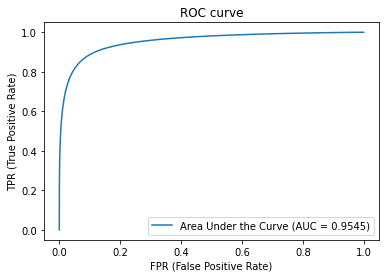

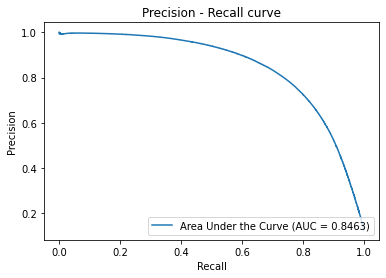

In [42]:

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

# ====== Evaluate the results
print("\n\n========  Evaluate the results =======================")
#predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")

# Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " +str(precision))

# Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print("\nJaccard similarity score: " +str(jaccard_index))

# F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " +str(F1_score))


## Save results

In [43]:
# Save the results
file_perf = open(path_experiment + 'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

# 8. Visualize the predicted results

In [44]:
!ls ../test/

all_groundTruths.png
all_originals.png
all_predictions.png
drive_performances.txt
DRIVE_Precision_recall.png
DRIVE_ROC.png
performances.txt
Precision_recall.png
ROC.png
sample_input_imgs.png
sample_input_masks.png
test_architecture.json
test_best_weights.h5
test_configuration.txt
test_last_weights.h5
test_model.png
test_Original_GroundTruth_Prediction0.png
test_Original_GroundTruth_Prediction10.png
test_Original_GroundTruth_Prediction11.png
test_Original_GroundTruth_Prediction12.png
test_Original_GroundTruth_Prediction13.png
test_Original_GroundTruth_Prediction14.png
test_Original_GroundTruth_Prediction15.png
test_Original_GroundTruth_Prediction16.png
test_Original_GroundTruth_Prediction17.png
test_Original_GroundTruth_Prediction18.png
test_Original_GroundTruth_Prediction19.png
test_Original_GroundTruth_Prediction1.png
test_Original_GroundTruth_Prediction2.png
test_Original_GroundTruth_Prediction3.png
test_Original_GroundTruth_Prediction4.png
test_Original_GroundTruth_Prediction5.png
t

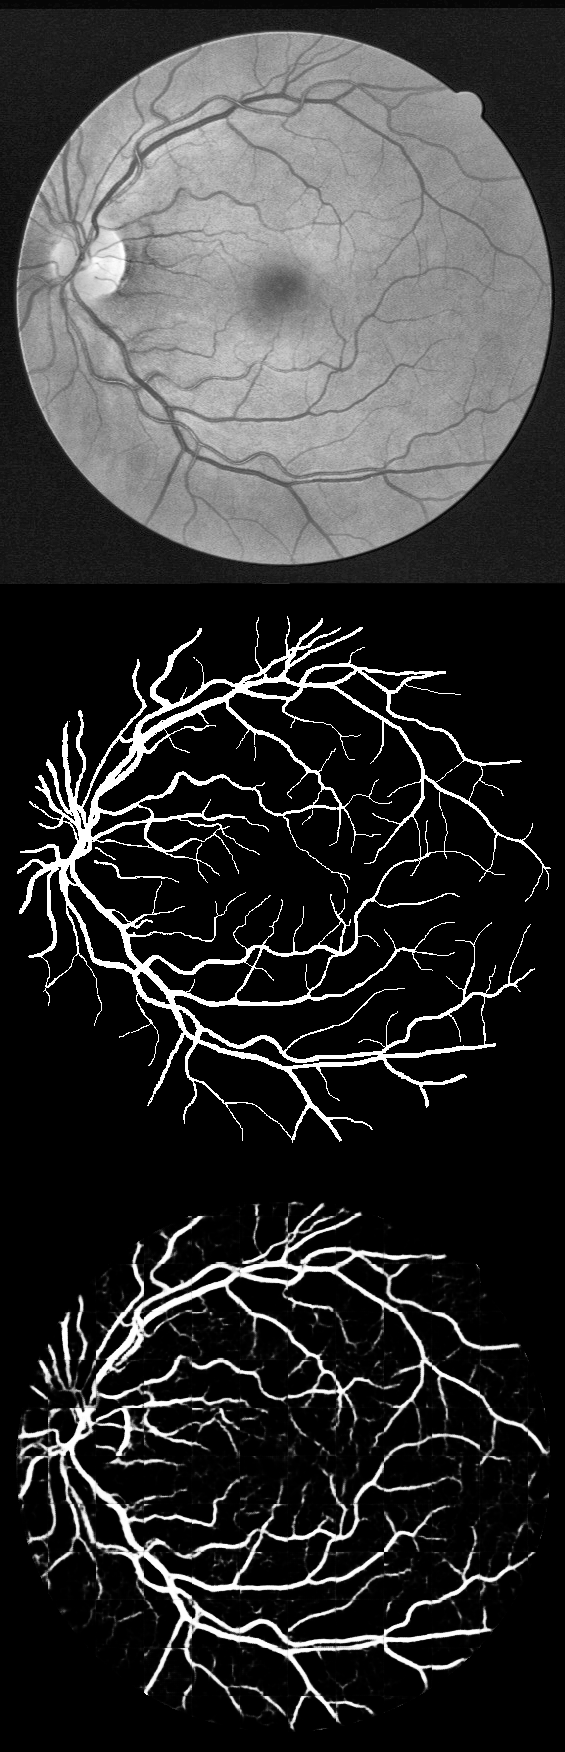

In [45]:
from IPython.display import Image
Image('../test/test_Original_GroundTruth_Prediction0.png')